In [1]:
import obspy as op

import sys
import matplotlib.pyplot as plt

import numpy as np
from numpy import moveaxis

import pandas as pd

# Visualization of a record and the prediction associated

Choice of event and station to visualise:

In [2]:
event = '2022001T213524'
station = 'MTNF'
network = 'FR'

## Records mseed

In [3]:
stream = op.read(f'./../mseed_demo/{event}/{network}_{station}_{event}.mseed')

Pre-process of the records:

In [4]:
stream.detrend('demean')
stream.taper(0.05)
stream.filter('highpass', freq=2, corners=4, zerophase=True)

3 Trace(s) in Stream:
FR.MTNF.00.HHE | 2022-01-01T21:35:31.000000Z - 2022-01-01T21:36:31.000000Z | 100.0 Hz, 6001 samples
FR.MTNF.00.HHN | 2022-01-01T21:35:31.000000Z - 2022-01-01T21:36:31.000000Z | 100.0 Hz, 6001 samples
FR.MTNF.00.HHZ | 2022-01-01T21:35:31.000000Z - 2022-01-01T21:36:31.000000Z | 100.0 Hz, 6001 samples

Plot of the 3-components seismograms

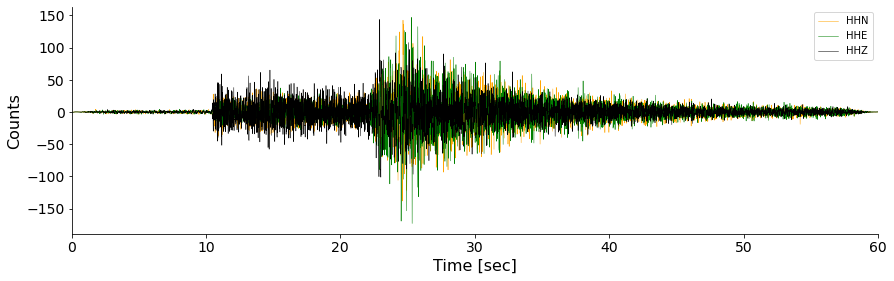

In [5]:
fig = plt.figure(figsize=(16, 9))
stream_c = stream.copy()
time = stream_c[0].times()
trN = stream_c.select(component='N')[0].data
trE = stream_c.select(component='E')[0].data
trZ = stream_c.select(component='Z')[0].data

# Plot
ax_sismo = fig.add_axes([0.1, 0.5, 0.7, 0.35])
ax_sismo.plot(time, trN, color='orange', linewidth=0.5,
              label='HHN')
ax_sismo.plot(time, trE, color='green', linewidth=0.5,
              label='HHE')
ax_sismo.plot(time, trZ, color='black', linewidth=0.5,
              label='HHZ')

# Labels
ax_sismo.set_ylabel('Counts', fontsize=16)
ax_sismo.set_xlabel('Time [sec]', fontsize=16)

# Ticks
ax_sismo.set_xlim(time.min(), time.max())
ax_sismo.spines['top'].set_visible(False)
ax_sismo.spines['right'].set_visible(False)
ax_sismo.tick_params(labelsize = 14)


# Legend
ax_sismo.legend()

plt.draw()


## Spectrograms

In [6]:
spectrogram = np.load(f'./../spectro_demo/{event}/{network}_{station}_{event}.npy', allow_pickle=True) 
spectro = moveaxis(spectrogram, 0, 2)
print(spectro.shape)

(237, 50, 3)


In [7]:
freqs = list(range(1, 51))
time = list(np.arange(0.5, 59.75, 0.25))
nyquist_f = 50.0

Plot of the spectrogram

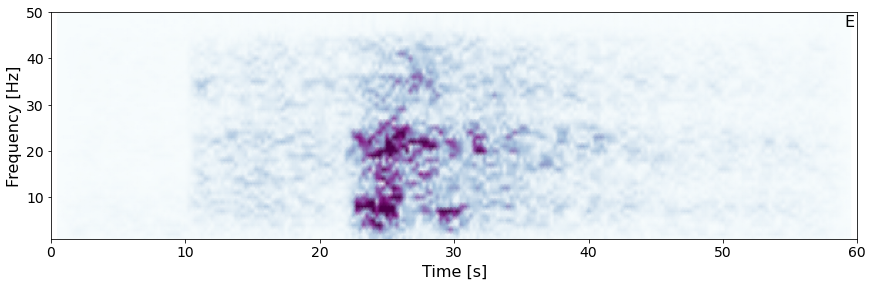

In [8]:
fig = plt.figure(figsize=(16, 9))
psd = spectro.copy()

# Compute the grid and get the data to plot on
T, F = np.meshgrid(time, freqs)
psd_mat = np.array(psd[:, :, 0])

# Define the colormap
cmap = plt.get_cmap('BuPu')

# Create Axes from a given Figure
ax_spectro = fig.add_axes([0.1, 0.1, 0.70, 0.35])  # spectrogram
#ax_cbar = fig.add_axes([0.81, 0.8, 0.01, 0.35])  # colorbar

# Plot the spectrogram
plot_spectro = ax_spectro.pcolormesh(T, F, psd_mat.T,
                                vmin=0, vmax=0.5,
                                cmap=cmap, shading='gouraud', label='HHE')

# Beautify spectrogram
ax_spectro.set_xlim((0.0, 60.0))
ax_spectro.set_ylabel('Frequency [Hz]', fontsize=16)
ax_spectro.set_xlabel('Time [s]', fontsize=16)
ax_spectro.tick_params(labelsize = 14)

# Plot text as legend
ax_spectro.text(x=59, y=47, s=f'{stream_c[0].stats.component}',
                color='black', fontsize=16)#, weight='bold')


plt.draw()



## Prediction station

In [9]:
pred_sta_csv = pd.read_csv("../output_demo/validation_station_level.csv")
pred_sta_csv = pd.DataFrame(pred_sta_csv)

In [10]:
prediction_sta = pred_sta_csv[pred_sta_csv['file_name'] == f'{network}_{station}_{event}']
prediction_sta

,file_name,station,label_cat,prob_nat,prob_ant,pred,nature
21,FR_MTNF_2022001T213524,MTNF,0,0.924,0.076,0,Natural


In [11]:
print()
print('Event:', event)
print('Station:', station)
print()
prob_sta_nat = prediction_sta['prob_nat'].values[0]*100
prob_sta_ant = prediction_sta['prob_ant'].values[0]*100
print('Probability of natural record:', prob_sta_nat, '%')
print('Probability of anthropogenic record:', prob_sta_ant, '%')


Event: 2022001T213524
Station: MTNF

Probability of natural record: 92.4 %
Probability of anthropogenic record: 7.6 %


## Prediction event

In [12]:
pred_net_csv = pd.read_csv("../output_demo/validation_network_level.csv")
pred_net_csv = pd.DataFrame(pred_net_csv)

In [13]:
prediction_net = pred_net_csv[pred_net_csv['event'] == f'{event}']
prediction_net

,event,label_cat,prob_nat,prob_ant,pred,nature
2,2022001T213524,0,0.961,0.039,0,Natural


In [14]:
print()
print('Event:', event)
print()
prob_net_nat = prediction_net['prob_nat'].values[0]*100
prob_net_ant = prediction_net['prob_ant'].values[0]*100
print('Probability of natural event:', prob_net_nat, '%')
print('Probability of anthropogenic event:', prob_net_ant, '%')


Event: 2022001T213524

Probability of natural event: 96.1 %
Probability of anthropogenic event: 3.9 %


## Visualization result

In [15]:
def plot_stream(stream: op.Trace,
                figure: plt.Figure):

    # Sort and select the traces
    stream_c = stream.copy()
    time = stream_c.times()
    
    # Plot
    ax_sismo = figure.add_axes([0.1, 0.5, 0.7, 0.35])
    ax_sismo.plot(time, stream_c, color='black', linewidth=0.5)
    
    # Ticks
    ax_sismo.set_xlim(time.min(), time.max())
    ax_sismo.spines['bottom'].set_visible(False)
    ax_sismo.spines['top'].set_visible(False)
    ax_sismo.spines['right'].set_visible(False)
    ax_sismo.spines['left'].set_visible(False)
    ax_sismo.xaxis.set_ticks([])
    ax_sismo.yaxis.set_ticks([])

    ax_sismo.text(x=59, y=max(stream_c.data)-5, s=f'{stream_c.stats.component}',
                color='black', fontsize=16)#, weight='bold')
    
    ax_sismo.text(x=2, y=max(stream_c.data)-5, s=f'{network}_{station}_{event}',
                color='black', fontsize=16)#, weight='bold')
    
    ax_sismo.text(x=50, y=min(stream_c.data)+5, s=f'Prob_nat: {prob_sta_nat} %',
                color='black', fontsize=16)#, weight='bold')
    ax_sismo.text(x=50, y=min(stream_c.data)-30, s=f'Prob_ant: {prob_sta_ant} %',
                color='black', fontsize=16)#, weight='bold')

    
    plt.draw()

    return None

In [16]:
def plot_spectro(time: list,
                 freq: np.ndarray,
                 psd: list,
                 fmax: float,
                 channel: str,
                 figure: plt.Figure) -> None:

    # Compute the grid and get the data to plot on
    T, F = np.meshgrid(time, freq)
    psd_mat = np.array(psd)
   
    # Define the colormap
    cmap = plt.get_cmap('BuPu')
   
    # Create Axes from a given Figure
    ax_spectro = figure.add_axes([0.1, 0.1, 0.7, 0.35])  # spectrogram
    ax_cbar = figure.add_axes([0.81, 0.1, 0.01, 0.35])  # colorbar

    # Plot the spectrogram
    spectro = ax_spectro.pcolormesh(T, F, psd_mat.T,
                                    vmin=0, vmax=0.5,
                                    cmap=cmap, shading='gouraud')

    # Beautify spectrogram
    ax_spectro.set_xlim((0.0, 60.0))
    ax_spectro.set_ylabel('Frequency [Hz]', fontsize=16)
    ax_spectro.set_xlabel('Time [s]', fontsize=16)
    ax_spectro.tick_params(labelsize = 14)

    # Plot text as legend
    ax_spectro.text(x=0.2, y=100, s=f'{channel}',
                    color='white', weight='bold')

    # Plot the colorbar
    cbar = figure.colorbar(spectro, orientation='vertical',
                           cax=ax_cbar, #format='%i',
                           fraction=0.05, aspect=30)

    cbar.ax.tick_params(labelsize=13)

    plt.draw()

    return None

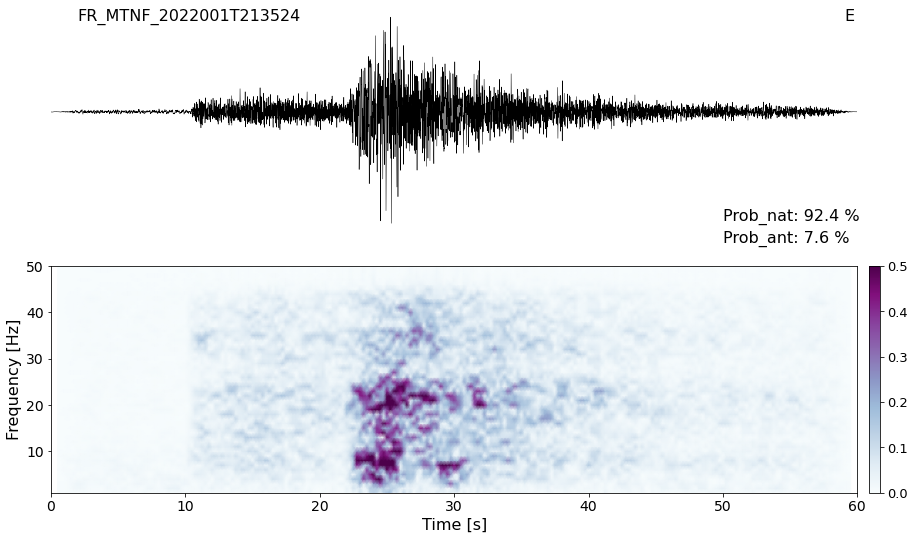

In [17]:
fig = plt.figure(figsize=(16, 9))

ax_sismo = plot_stream(stream=stream[0],
                       figure=fig)
ax_spectro = plot_spectro(channel='HHZ', time=time,
                          freq=freqs, psd=psd[:, :, 0],
                          figure=fig, fmax=nyquist_f)